***

<center><u><H1>Convolutional Neural Network: classificazione di time-series</H1></u></center>

***

***
# Il dataset

Sebbene siano state sviluppate per lavorare con immagini bidimensionali, le reti neurali convoluzionali sono delle ottime soluzioni anche per le predizioni sulle serie temporali (time-series). E' un tema particolarmente interessante, dato che coinvolge una componente temporale nel dataset; ad esempio, lo si potrebbe applicare alla predizione dei coefficienti di canale di un sistema di comunicazione, temperature di sensori, movimento degli utenti, etc. 

Lavoriamo con un esempio semplice (basato sull'esempio di Keras a [questo link](https://keras.io/examples/timeseries/timeseries_classification_from_scratch/)): il dataset [FordA](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/) fornito dalla University of California, Riverside (UCR). Questo dataset contiene 3601 osservazioni nel train set e 1320 nel test set. Ogni serie temporale corrisponde alla misura del rumore di un motore, fornita da un sensore al suo interno. L'obiettivo è quello di rilevare automaticamente la presenza di un problema nel motore: è un problema di classificazione binaria.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, models, Input
import numpy as np
import pandas as pd

Il dataset è disponibile a [questo link](https://www.timeseriesclassification.com/description.php?Dataset=FordA) e su VLE (la versione su VLE è convertita in file .csv per una maggiore comodità di importazione):

In [2]:
df_train = pd.read_csv('00_datasets/FordA/FordA_TRAIN.csv')
df_test = pd.read_csv('00_datasets/FordA/FordA_TEST.csv')

Osservando i dataset, si può notare come la variabile da predire sia nella prima colonna. Andiamo quindi a separare IV e DV, convertendo anche in array NumPy i dati: int per la DV e float per le IV.

In [3]:
X_train = df_train.iloc[:, 1:].to_numpy()
X_test = df_test.iloc[:, 1:].to_numpy()
y_train = df_train.iloc[:, 0].to_numpy().astype('int')
y_test = df_test.iloc[:, 0].to_numpy().astype('int')

Le classi sono -1 o 1, per indicare la presenza o meno di una anomalia. Possiamo graficare un esempio di time-series per classe:

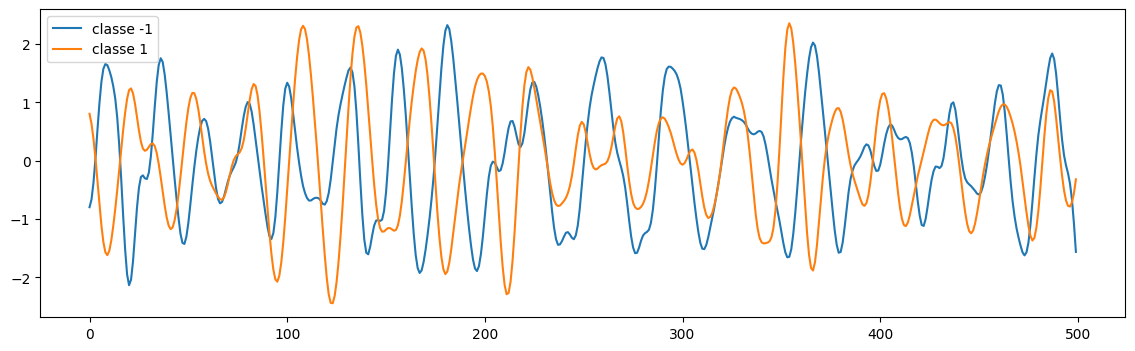

In [4]:
classes = np.unique(y_train)

plt.figure(figsize=(14, 4))
for c in classes:
    c_train = X_train[y_train == c]
    plt.plot(c_train[0], label=f'classe {c}')
plt.legend(loc='best')
plt.show()

## Feature scaling e data transformation

Come (quasi) sempre, è necessario applicare il feature scaling ai dati prima di procedere con la rete neurale. Questo può essere fatto in due modi: applicando direttamente uno StandardScaler oppure implementando un layer di normalizzazione. Questo dataset, tuttavia, è già stato normalizzato con uno z-score, quindi i dati sono tutti a media nulla e deviazione standard unitaria.

Questo dataset contiene una **univariate time-series**: si ha una singola variabile che varia nel tempo. Tuttavia, esistono anche **multivariate time-series** in cui si hanno più variabili che variano nel tempo. Potremmo pensare di creare una rete neurale già flessibile per venire applicata anche al caso multivariate: per fare ciò, è sufficiente inserire una terza dimensione che rappresenti i canali:  

In [5]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (3601, 500, 1)
Test set: (1320, 500, 1)


Per concludere, è necessario che la variabile dipendente sia positiva o nulla: convertiamo la classe -1 nella classe 0.

In [6]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# CNN 1D per time-series

## Design della rete

Utilizziamo la rete proposta da Keras per questo dataset, anche se noi non utilizzeremo i callback e l'ulteriore divisione del training set tra train e validation:

In [8]:
input_layer = Input(shape=X_train.shape[1:])

conv1 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.ReLU()(conv1)

conv2 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.ReLU()(conv2)

conv3 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.ReLU()(conv3)

gap = layers.GlobalAveragePooling1D()(conv3)

output_layer = layers.Dense(units=2, activation="sigmoid")(gap)

model = models.Model(inputs=input_layer, outputs=output_layer)

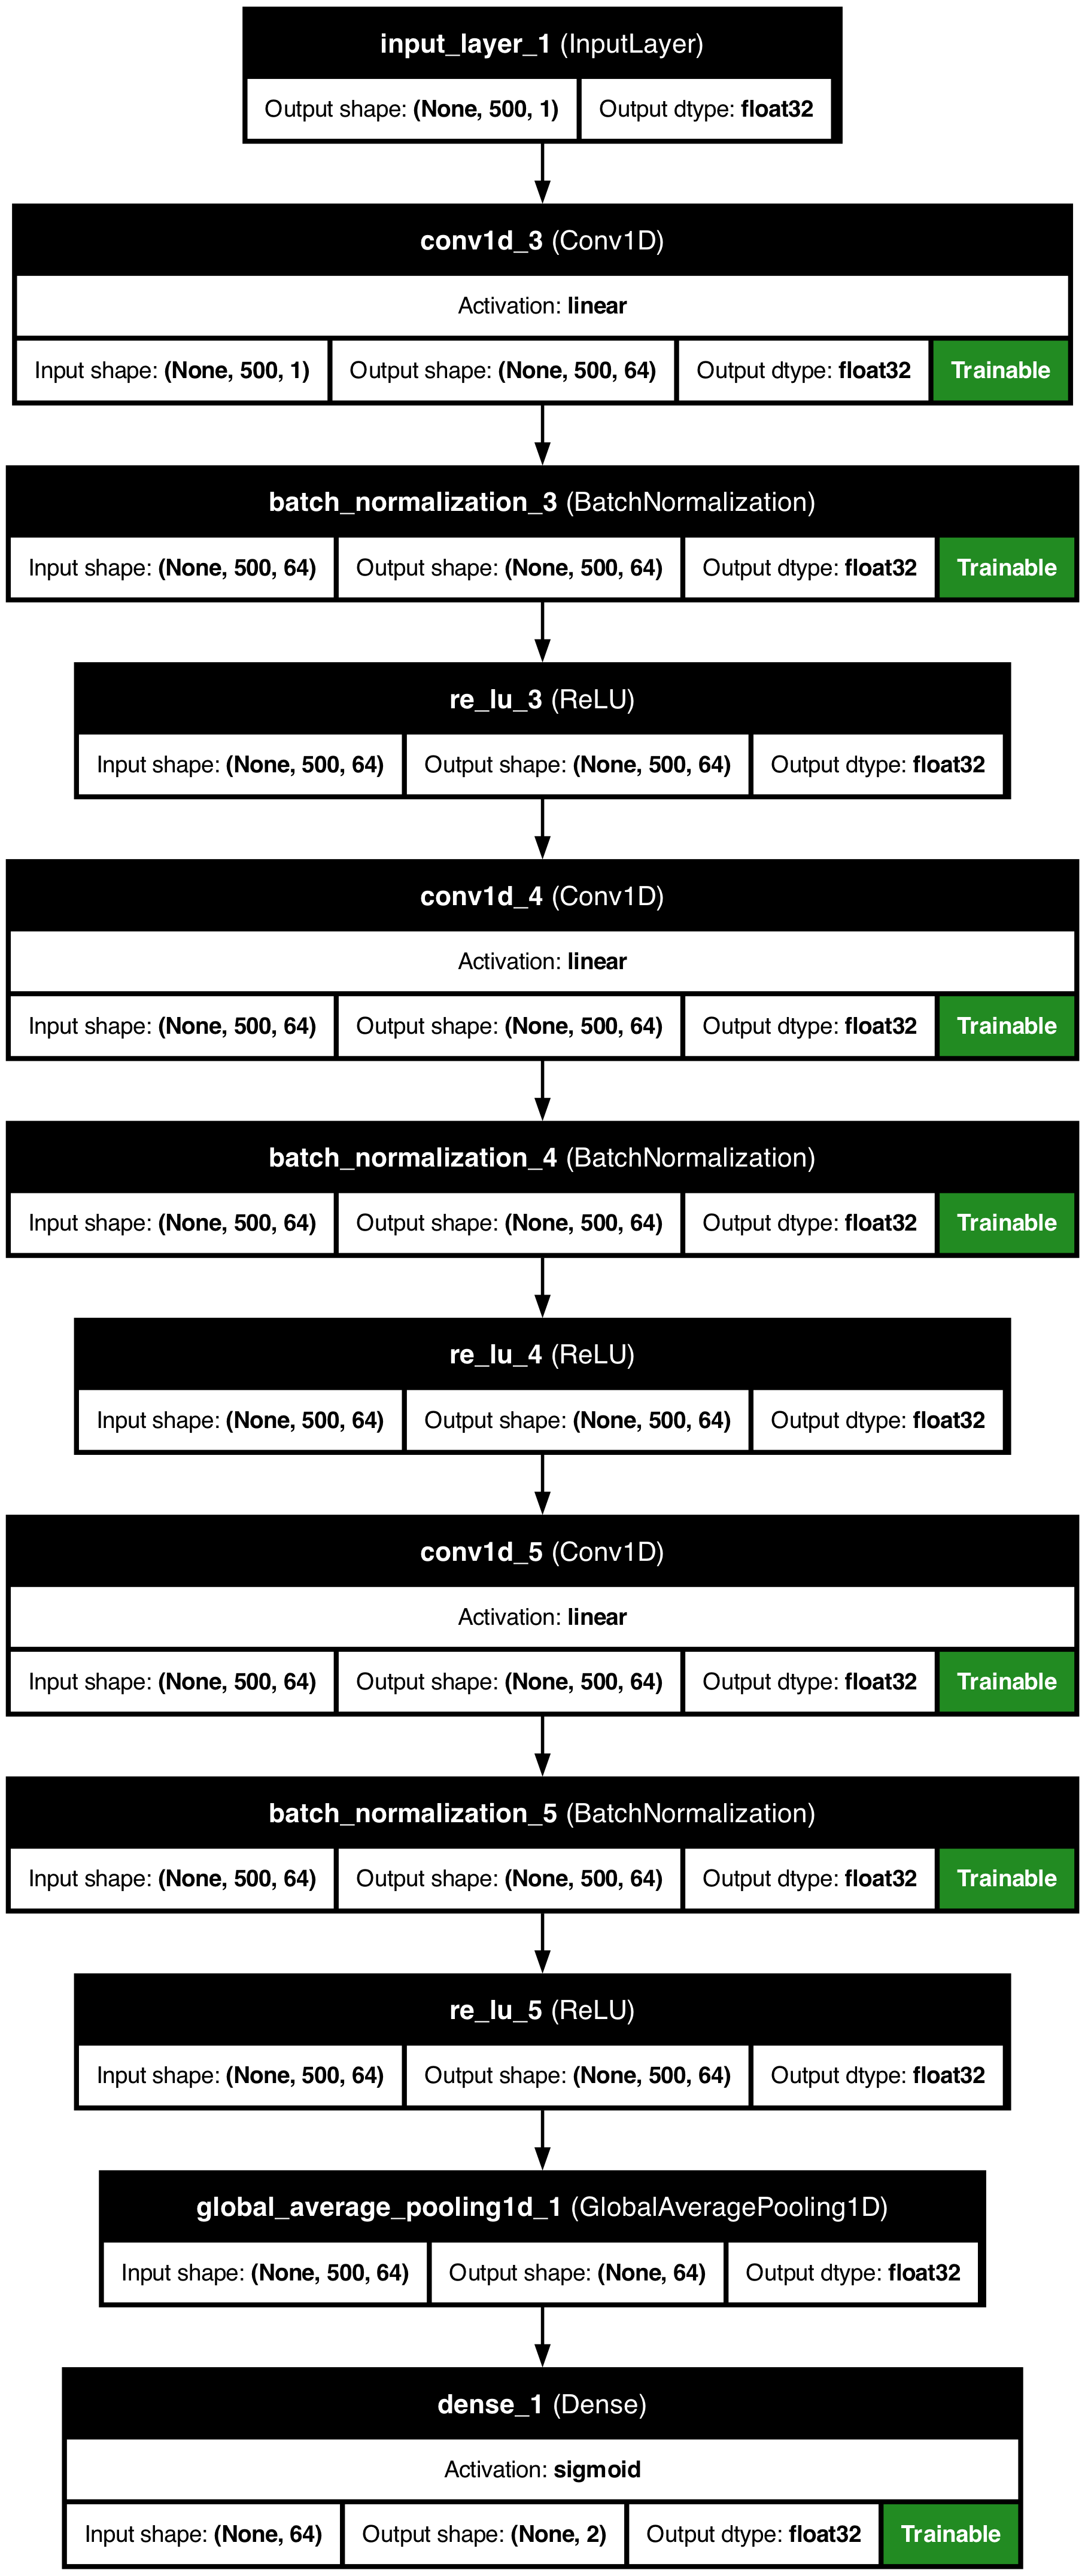

In [9]:
tf.keras.utils.plot_model(
    model,
    rankdir='TB',
    show_shapes=True,
    show_layer_names=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True
)

Questa rete ci permette di introdurre alcune nuove tipologie di layer:
- [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/): è una delle tecniche di regolarizzazione di una rete neruale, ovvero quelle tecniche che permettono di addestrare più rapidamente una rete (permettono di utilizzare learning rate maggiori e riducono l'effetto noto come [internal covariate shift](https://medium.com/analytics-vidhya/internal-covariate-shift-an-overview-of-how-to-speed-up-neural-network-training-3e2a3dcdd5cc)) e di migliorarne le prestazioni (altre soluzioni sono legate all'inizializzazione dei pesi, early stopping e layer di dropout). La batch normalization viene eseguita in due step:
    - normalizzazione dell'input: si trasformano i dati per avere media nulla e deviazione standard unitaria;
    - rescaling: tramite due parametri addestrabili, noti come re-scaling e shifting, si cerca di modificare i valori ottenuti per riportarli, sebbene scalati, ad una distribuzione simile a quella in ingresso come forma e posizione.
- [ReLU](https://keras.io/api/layers/activation_layers/relu/): un layer per la funzione di attivazione ReLU. La configurazione di default, che è quella utilizzata qui, non prevede un limite al massimo, il coefficiente angolare per gli ingressi negativi è nullo (ReLU classica) e il valore di soglia è 0;
- [GlobalAveragePooling1D](https://keras.io/api/layers/pooling_layers/global_average_pooling1d/): calcola la media temporale (o spaziale, se questo fosse il dominio di applicazione) dei canali passati in ingresso.

## Addestramento e prestazioni

Per l'addestramento, consideriamo 500 epoche con batch da 32, sempre ricorrendo all'ottimizzatore Adam. Per quanto riguarda la funzione di costo, essendo un problema di classificazione ricorriamo ancora alla [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy):

In [10]:
my_seed = 0
tf.keras.utils.set_random_seed(my_seed)

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.5853 - sparse_categorical_accuracy: 0.6772
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.4621 - sparse_categorical_accuracy: 0.7698
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.4325 - sparse_categorical_accuracy: 0.7785
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.4211 - sparse_categorical_accuracy: 0.7887
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.7875
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.4084 - sparse_categorical_accuracy: 0.7940
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3996 - sparse_categorical_accuracy: 0.7999
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.3928 - sparse_categorical_accuracy: 0.8070
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.3849 - sparse_categorical_accuracy: 0.8141
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

Test accuracy 0.928787887096405
Test loss 0.16894002258777618


In [12]:
loss = pd.DataFrame(history.history)
loss.plot()

<Axes: >

A [questo link](https://keras.io/examples/timeseries/timeseries_classification_from_scratch/) c'è un tutorial su questo dataset in cui diverse soluzioni avanzate relative alle reti neurali permettono di ottenere una accuratezza sul test set del 96%.